In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression, Ridge

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
np.random.seed(42)
torch.manual_seed(111)

FEATURE_DIM = 64

def init_weights(m):
    #torch.manual_seed(1)
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
        torch.nn.init.uniform_(m.bias)

class NoPI(nn.Module):
    def __init__(self):
        super(NoPI, self).__init__()
        self.fc1 = nn.Linear(1, FEATURE_DIM)
        self.fc2 = nn.Linear(FEATURE_DIM, FEATURE_DIM)
        self.fc3 = nn.Linear(FEATURE_DIM, 1)

    def forward(self, x, a=None, return_representation=False):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        
        if return_representation:
            return x
        
        x = self.fc3(x)
        return x, x
    
class TRAM(nn.Module):
    def __init__(self):
        super(TRAM, self).__init__()
        self.fc1 = nn.Linear(1, FEATURE_DIM)
        self.fc2 = nn.Linear(FEATURE_DIM, FEATURE_DIM)
        self.fc_a = nn.Linear(1, FEATURE_DIM)
        # No PI head
        self.head1 = nn.Sequential(
            nn.Linear(FEATURE_DIM, 1)
        )
        # PI head
        self.head2 = nn.Sequential(
            nn.Linear(FEATURE_DIM, FEATURE_DIM),
            nn.Tanh(),
            nn.Linear(FEATURE_DIM, 1)
        )

    def forward(self, x, a=None, return_representation=False):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        if return_representation:
            return x
        # stop gradient for no PI head using .detach()
        y_pred1 = self.head1(x.detach())
        
        if a is not None:
            #xa = torch.cat((x, a), dim=1)
            a = self.fc1(a)
            xa = x + a
            y_pred2 = self.head2(xa)
            return y_pred1, y_pred2

        return y_pred1, None

In [4]:
def fit_model(X, A, Y, model_class, num_epochs=20, lr=0.01):
    model = model_class()
    model.apply(init_weights)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        _, outputs = model(X, A)
        loss = criterion(outputs, Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    return model

## TRAM synthetic experiment I

$a \sim Bermoulli(0.3)$ - indicator of noisy annotator

$x \in [0, 1], v \sim Unif(-1, 1), \epsilon \sim N(0, 0.1)$

$$y = (1-a) \sin (2\pi x) + av + \epsilon$$


In [5]:
def fit_regression(features, y):
    # fit l2 regression
    alpha = .5  # Regularization strength
    I = np.eye(features.shape[1])
    I[0, 0] = 0  # Don't regularize the bias term
    weights = np.linalg.inv(features.T @ features + alpha * I) @ features.T @ y
    
    return weights

def run_experiment(x, a, y, num_epochs, include_uncorrupted=False):
    y_preds = {}
    x_tensor = torch.tensor(x).float().unsqueeze(1)
    a_tensor = torch.tensor(a).float().unsqueeze(1)
    y_tensor = torch.tensor(y).float().unsqueeze(1)

    # fit NoPI and TRAM
    for model_class in [NoPI, TRAM]:
        # fit NN
        model = fit_model(x_tensor, a_tensor, y_tensor, model_class, num_epochs=num_epochs)
        
        with torch.no_grad():
            features = model(torch.from_numpy(x).float().unsqueeze(1), return_representation=True).numpy()
            features_pred = model(torch.from_numpy(x_pred).float().unsqueeze(1), return_representation=True).numpy()
        
        # fit l2 regression
        weights = fit_regression(features, y)
        # predict final value
        y_preds[model.__class__.__name__] = features_pred @ weights   

    # fit NoPI model to uncorrupted data
    model = fit_model(x_tensor[a_tensor==0].unsqueeze(1), 
                      a_tensor[a_tensor==0].unsqueeze(1), 
                      y_tensor[a_tensor==0].unsqueeze(1), 
                      NoPI, num_epochs=num_epochs)

    with torch.no_grad():
        features = model(torch.from_numpy(x[a==0]).float().unsqueeze(1), return_representation=True).numpy()
        features_pred = model(torch.from_numpy(x_pred).float().unsqueeze(1), return_representation=True).numpy()

    # fit l2 regression
    weights = fit_regression(features, y[a==0])
    #predict final value
    if include_uncorrupted:
        y_preds['Uncorrupted'] = features_pred @ weights

    # fit TRAM with all zeros instead of priv info
    zero_tensor = torch.zeros_like(a_tensor)
    
    model = fit_model(x_tensor, zero_tensor, y_tensor, TRAM, num_epochs=num_epochs)
    
    with torch.no_grad():
        features = model(torch.from_numpy(x).float().unsqueeze(1), return_representation=True).numpy()
        features_pred = model(torch.from_numpy(x_pred).float().unsqueeze(1), return_representation=True).numpy()

    # fit l2 regression
    weights = fit_regression(features, y)
    # predict final value
    y_preds['TRAM zeros'] = features_pred @ weights

    return y_preds

In [6]:
num_points = 2500
x = np.random.rand(num_points)
a = np.random.binomial(1, 0.3, num_points)
v = np.random.uniform(-1, 1, num_points)
epsilon = np.random.normal(0, 0.1, num_points)

y = (1 - a) * np.sin(2 * np.pi * x) + a * v + epsilon

x_pred = np.linspace(0, 1, num_points)
y_true = np.sin(2 * np.pi * x_pred)

num_epochs = 10
y_preds_10 = run_experiment(x, a, y, num_epochs)

num_epochs = 200
y_preds_200 = run_experiment(x, a, y, num_epochs)

Epoch [10/10], Loss: 0.5418
Epoch [10/10], Loss: 0.4453
Epoch [10/10], Loss: 0.5012
Epoch [10/10], Loss: 0.5357
Epoch [200/200], Loss: 0.2004
Epoch [200/200], Loss: 0.1079
Epoch [200/200], Loss: 0.0109
Epoch [200/200], Loss: 0.1982


NoPI loss: 0.131
TRAM loss: 0.07
TRAM zeros loss: 0.055


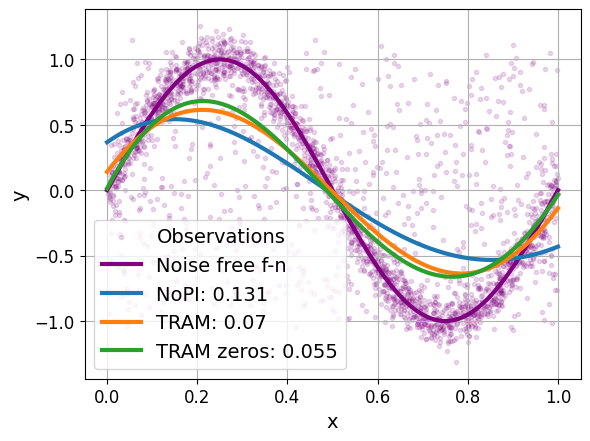

In [7]:
num_epochs = 10
plt.scatter(x, y, c='purple', label='Observations', marker='.', alpha=0.15)
plt.plot(x_pred, y_true, c='purple', label='Noise free f-n', lw=3)
for key, y_pred in y_preds_10.items():
    loss = round(mean_squared_error(y_pred, y_true), 3)
    print(f'{key} loss: {loss}')
    plt.plot(x_pred, y_pred, label=key + ': ' + str(loss), lw=3)
plt.xlabel('x')
plt.ylabel('y')
#plt.title(f'Regression experiment trained over {num_epochs} epochs with {num_points} samples')
plt.legend()
plt.grid(True)
plt.savefig(f'pics/reg_exp_{num_epochs}_{num_points}.pdf', bbox_inches='tight')
plt.show()

NoPI loss: 0.037
TRAM loss: 0.036
TRAM zeros loss: 0.036


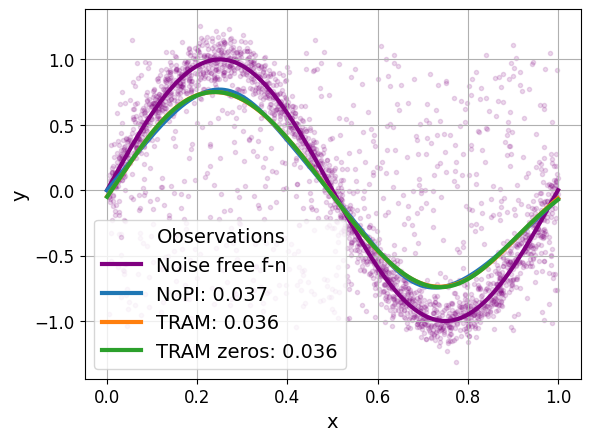

In [8]:
num_epochs = 200
plt.scatter(x, y, c='purple', label='Observations', marker='.', alpha=0.15)
plt.plot(x_pred, y_true, c='purple', label='Noise free f-n', lw=3)
for key, y_pred in y_preds_200.items():
    loss = round(mean_squared_error(y_pred, y_true), 3)
    print(f'{key} loss: {loss}')
    plt.plot(x_pred, y_pred, label=key + ': ' + str(loss), lw=3)
plt.xlabel('x')
plt.ylabel('y')
#plt.title(f'Regression experiment trained over {num_epochs} epochs with {num_points} samples')
plt.legend()
plt.grid(True)
plt.savefig(f'pics/reg_exp_{num_epochs}_{num_points}.pdf', bbox_inches='tight')
plt.show()

In [9]:
num_points = 10000
x = np.random.rand(num_points)
a = np.random.binomial(1, 0.3, num_points)
v = np.random.uniform(-1, 1, num_points)
epsilon = np.random.normal(0, 0.1, num_points)

y = (1 - a) * np.sin(2 * np.pi * x) + a * v + epsilon

x_pred = np.linspace(0, 1, num_points)
y_true = np.sin(2 * np.pi * x_pred)

num_epochs = 400
y_preds_400 = run_experiment(x, a, y, num_epochs)

Epoch [400/400], Loss: 0.2047
Epoch [400/400], Loss: 0.1064
Epoch [400/400], Loss: 0.0101
Epoch [400/400], Loss: 0.2045


NoPI loss: 0.041
TRAM loss: 0.041
TRAM zeros loss: 0.041


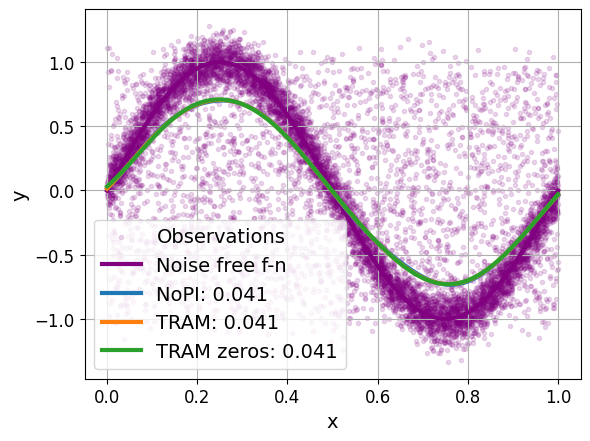

In [10]:
plt.scatter(x, y, c='purple', label='Observations', marker='.', alpha=0.15)
plt.plot(x_pred, y_true, c='purple', label='Noise free f-n', lw=3)
for key, y_pred in y_preds_400.items():
    loss = round(mean_squared_error(y_pred, y_true), 3)
    print(f'{key} loss: {loss}')
    plt.plot(x_pred, y_pred, label=key + ': ' + str(loss), lw=3)
plt.xlabel('x')
plt.ylabel('y')
#plt.title(f'Regression experiment trained over {num_epochs} epochs with {num_points} samples')
plt.legend()
plt.grid(True)
plt.savefig(f'pics/reg_exp_{num_epochs}_{num_points}.pdf', bbox_inches='tight')
plt.show()

In [11]:
def generate_data(num_points):
    x = np.random.rand(num_points)
    a = np.random.binomial(1, 0.3, num_points)
    v = np.random.uniform(-1, 1, num_points)
    epsilon = np.random.normal(0, 0.1, num_points)
    
    y = (1 - a) * np.sin(2 * np.pi * x) + a * v + epsilon
    x_pred = np.linspace(0, 1, num_points)
    y_true = np.sin(2 * np.pi * x_pred)

    return x, a, y, x_pred, y_true

### Sample efficiency

In [12]:
models = ['NoPI', 'TRAM', 'TRAM zeros', 'Uncorrupted']
num_epochs = 200
points = [100, 250, 500, 750, 1000, 2500, 5000, 7500, 10000]
num_runs = 10

result_sample_ef = np.zeros((len(points), len(models), num_runs))

for k in range(num_runs):
    for j, num_points in enumerate(points):
        x, a, y, x_pred, y_true = generate_data(num_points)
        x_tensor = torch.tensor(x).float().unsqueeze(1)
        a_tensor = torch.tensor(a).float().unsqueeze(1)
        y_tensor = torch.tensor(y).float().unsqueeze(1)

        y_pred = run_experiment(x, a, y, num_epochs, include_uncorrupted=True)
        for l, model_class in enumerate(models):
            y_loss = mean_squared_error(y_pred[models[l]], y_true)
            result_sample_ef[j, l, k] += y_loss

Epoch [200/200], Loss: 0.1588
Epoch [200/200], Loss: 0.0439
Epoch [200/200], Loss: 0.0083
Epoch [200/200], Loss: 0.1612
Epoch [200/200], Loss: 0.2371
Epoch [200/200], Loss: 0.1061
Epoch [200/200], Loss: 0.0110
Epoch [200/200], Loss: 0.2350
Epoch [200/200], Loss: 0.2089
Epoch [200/200], Loss: 0.1074
Epoch [200/200], Loss: 0.0125
Epoch [200/200], Loss: 0.2082
Epoch [200/200], Loss: 0.2281
Epoch [200/200], Loss: 0.1061
Epoch [200/200], Loss: 0.0102
Epoch [200/200], Loss: 0.2281
Epoch [200/200], Loss: 0.2153
Epoch [200/200], Loss: 0.1144
Epoch [200/200], Loss: 0.0111
Epoch [200/200], Loss: 0.2138
Epoch [200/200], Loss: 0.2154
Epoch [200/200], Loss: 0.1045
Epoch [200/200], Loss: 0.0144
Epoch [200/200], Loss: 0.2116
Epoch [200/200], Loss: 0.2090
Epoch [200/200], Loss: 0.1125
Epoch [200/200], Loss: 0.0131
Epoch [200/200], Loss: 0.2053
Epoch [200/200], Loss: 0.2268
Epoch [200/200], Loss: 0.1122
Epoch [200/200], Loss: 0.0163
Epoch [200/200], Loss: 0.2222
Epoch [200/200], Loss: 0.2180
Epoch [200

### Convergance rate

In [13]:
models = ['NoPI', 'TRAM', 'TRAM zeros', 'Uncorrupted']
epochs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200]
num_runs = 10

result_conv_rate = np.zeros((len(models), len(epochs), num_runs))

for k in range(num_runs):
    x, a, y, x_pred, y_true = generate_data(2500)
    x_tensor = torch.tensor(x).float().unsqueeze(1)
    a_tensor = torch.tensor(a).float().unsqueeze(1)
    y_tensor = torch.tensor(y).float().unsqueeze(1)
    
    for l, num_epochs in enumerate(epochs):
        y_pred = run_experiment(x, a, y, num_epochs, include_uncorrupted=True)
        for j, model_class in enumerate(models):
            y_loss = mean_squared_error(y_pred[models[j]], y_true)
            result_conv_rate[j, l, k] += y_loss

Epoch [10/10], Loss: 0.4216
Epoch [10/10], Loss: 0.4893
Epoch [10/10], Loss: 0.3078
Epoch [10/10], Loss: 0.4883
Epoch [20/20], Loss: 0.3602
Epoch [20/20], Loss: 0.3281
Epoch [20/20], Loss: 0.2088
Epoch [20/20], Loss: 0.3871
Epoch [30/30], Loss: 0.3139
Epoch [30/30], Loss: 0.2830
Epoch [30/30], Loss: 0.2002
Epoch [30/30], Loss: 0.3160
Epoch [40/40], Loss: 0.3127
Epoch [40/40], Loss: 0.1963
Epoch [40/40], Loss: 0.1922
Epoch [40/40], Loss: 0.2866
Epoch [50/50], Loss: 0.3074
Epoch [50/50], Loss: 0.1775
Epoch [50/50], Loss: 0.1685
Epoch [50/50], Loss: 0.2748
Epoch [60/60], Loss: 0.2984
Epoch [60/60], Loss: 0.1558
Epoch [60/60], Loss: 0.1461
Epoch [60/60], Loss: 0.2558
Epoch [70/70], Loss: 0.2720
Epoch [70/70], Loss: 0.1503
Epoch [70/70], Loss: 0.1278
Epoch [70/70], Loss: 0.2541
Epoch [80/80], Loss: 0.2842
Epoch [80/80], Loss: 0.1309
Epoch [80/80], Loss: 0.1169
Epoch [80/80], Loss: 0.2547
Epoch [90/90], Loss: 0.2582
Epoch [90/90], Loss: 0.1373
Epoch [90/90], Loss: 0.0700
Epoch [90/90], Loss:

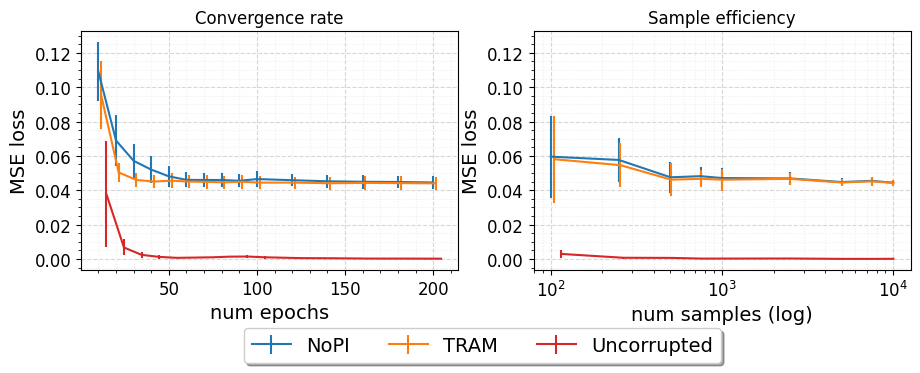

In [14]:
from matplotlib.transforms import Affine2D
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10.7, 3.1))

models = ['NoPI', 'TRAM', 'TRAM zeros', 'Uncorrupted']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
#markers = ['o', 'v']

for j in [0,1,3]:
    trans = Affine2D().translate(+j*1.5, 0.0) + ax[0].transData
    label = models[j]
    #plt.plot(epochs, result[i, j], color=colors[i], marker=markers[j], label=label, lw=1)
    ax[0].errorbar(epochs, 
                 result_conv_rate[j].mean(axis=-1), 
                 result_conv_rate[j].std(axis=-1), 
                 label=label, color=colors[j], fmt='-', transform=trans)#, marker=markers[j])

for j in [0,1,3]:
    trans = Affine2D().translate(+j*5, 0.0) + ax[1].transData
    label = models[j]
    #plt.plot(epochs, result[i, j], color=colors[i], marker=markers[j], label=label, lw=1)
    ax[1].errorbar(points, 
                 result_sample_ef[:, j].mean(axis=-1), 
                 result_sample_ef[:, j].std(axis=-1), 
                 color=colors[j], fmt='-', transform=trans)#, marker=markers[j])

ax[0].grid(visible=True, which='major', linestyle='--', alpha=0.5)
ax[0].minorticks_on()
ax[0].grid(visible=True, which='minor', linestyle=':', alpha=0.2)
ax[0].set_xlabel('num epochs')
ax[0].set_ylabel('MSE loss')
ax[0].title.set_text('Convergence rate')

ax[1].grid(visible=True, which='major', linestyle='--', alpha=0.5)
ax[1].minorticks_on()
ax[1].grid(visible=True, which='minor', linestyle=':', alpha=0.2)
ax[1].set_xlabel('num samples (log)')
ax[1].set_xscale('log')
ax[1].set_ylabel('MSE loss')
ax[1].title.set_text('Sample efficiency')
ax[1].yaxis.set_tick_params(labelbottom=True)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.047),
          ncol=4, fancybox=True, shadow=True)

plt.savefig('pics/conv_rate_sample_eff_tram_original.pdf', bbox_inches='tight')

## TRAM synthetic experiment II

### This is the second experiment from TRAM paper. We are currently not using it anywhere.

$a \sim Bermoulli(0.3)$ - indicator of noisy annotator

$x \in [0, 1], v \sim Unif(-1, 1), \epsilon \sim N(0, 0.4)$

$$y_{score} = (1-a) (\sin (2\pi x) + 1) / 2 + av + \epsilon$$

$y = 1 * I(y_{score} > 0.5) + 0 * I(y_{score} <= 0.5)$


In [15]:
num_points = 20000
x = np.random.uniform(-2, 2, num_points)
a = np.random.binomial(1, 0.3, num_points)
v = np.random.uniform(0, 1, num_points)
epsilon = np.random.normal(0, 0.4, num_points)

y_score = (1 - a) * (np.sin(2 * np.pi * x) + 1) / 2 + a * v + epsilon
y = 1 * (y_score > 0.5) + 0 * (y_score <= 0.5)

x_pred = np.linspace(-2, 2, num_points)
y_true = (np.sin(2 * np.pi * x_pred) + 1) / 2

In [16]:
y_preds = {}
x_tensor = torch.tensor(x).float().unsqueeze(1)
a_tensor = torch.tensor(a).float().unsqueeze(1)
y_tensor = torch.tensor(y).float().unsqueeze(1)
num_epochs = 400

for model_class in [NoPI, TRAM]:
    # fit NN
    model = fit_model(x_tensor, a_tensor, y_tensor, model_class, num_epochs=num_epochs)
    
    with torch.no_grad():
        features = model(torch.from_numpy(x).float().unsqueeze(1), return_representation=True).numpy()
        features_pred = model(torch.from_numpy(x_pred).float().unsqueeze(1), return_representation=True).numpy()
    
    # fit l2 regression
    logistic_model = LogisticRegression(penalty='l2', solver='lbfgs', C=1.)
    logistic_model.fit(features, y)
    y_preds[model.__class__.__name__] = logistic_model.predict_proba(features_pred)[:, 1]

# fit NoPI model to uncorrupted data
model = fit_model(x_tensor[a_tensor==0].unsqueeze(1), 
                  a_tensor[a_tensor==0].unsqueeze(1), 
                  y_tensor[a_tensor==0].unsqueeze(1), 
                  NoPI, num_epochs=num_epochs)

with torch.no_grad():
    features = model(torch.from_numpy(x[a==0]).float().unsqueeze(1), return_representation=True).numpy()
    features_pred = model(torch.from_numpy(x_pred).float().unsqueeze(1), return_representation=True).numpy()

# fit l2 regression
logistic_model = LogisticRegression(penalty='l2', solver='lbfgs', C=1.)
logistic_model.fit(features, y[a==0])
y_preds[model.__class__.__name__] = logistic_model.predict_proba(features_pred)[:, 1]

Epoch [400/400], Loss: 0.2124


/home/danilprov/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Epoch [400/400], Loss: 0.1910


/home/danilprov/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Epoch [400/400], Loss: 0.1671


/home/danilprov/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


NoPI loss: 0.007
TRAM loss: 0.025


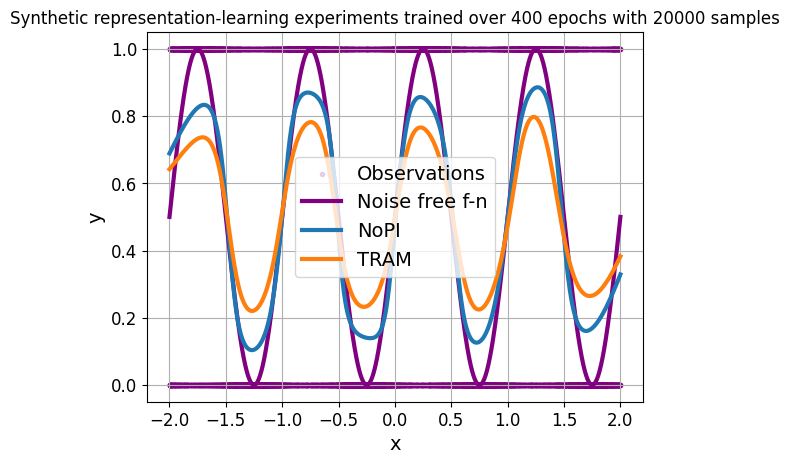

In [17]:
plt.scatter(x, y, c='purple', label='Observations', marker='.', alpha=0.15)
plt.plot(x_pred, y_true, c='purple', label='Noise free f-n', lw=3)
for key, y_pred in y_preds.items():
    print(f'{key} loss: {round(mean_squared_error(y_pred, y_true), 3)}')
    plt.plot(x_pred, y_pred, label=key, lw=3)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Synthetic representation-learning experiments trained over {num_epochs} epochs with {num_points} samples')
plt.legend()
plt.grid(True)
plt.show()

## CLICK BOT synthetic experiment


### Individual example (from development)

In [18]:
num_points = 40000
x = np.random.rand(num_points)
a = np.random.binomial(1, 0.3, num_points)
v = np.random.uniform(-1, 1, num_points)
#a = np.zeros(num_points)

y_score = (1-a) * np.sin(2 * np.pi * x) + a * np.random.uniform(-1, 1, num_points) #np.random.binomial(1, 0.7, num_points)
#y_score = (1-a) * np.sin(2 * np.pi * x) + a * np.cos(2 * np.pi * x)
y = np.random.binomial(1, (y_score + 1) / 2, num_points)

x_pred = np.linspace(0, 1, num_points)
y_true = np.sin(2 * np.pi * x_pred)

In [19]:
y_preds = {}
x_tensor = torch.tensor(x).float().unsqueeze(1)
a_tensor = torch.tensor(a).float().unsqueeze(1)
y_tensor = torch.tensor(y).float().unsqueeze(1)
num_epochs = 400

for model_class in [NoPI, TRAM]:
    # fit NN
    model = fit_model(x_tensor, a_tensor, y_tensor, model_class, num_epochs=num_epochs)
    
    # fit l2 regression
    with torch.no_grad():
        features = model(torch.from_numpy(x).float().unsqueeze(1), return_representation=True).numpy()
        features_pred = model(torch.from_numpy(x_pred).float().unsqueeze(1), return_representation=True).numpy()
        
    logistic_model = LogisticRegression(penalty='l2', solver='saga', C=1.)
    logistic_model.fit(features, y)
    y_preds[model.__class__.__name__] = logistic_model.predict_proba(features_pred)[:, 1]


# fit NoPI model to uncorrupted data
model = fit_model(x_tensor[a_tensor==0].unsqueeze(1), 
                  a_tensor[a_tensor==0].unsqueeze(1), 
                  y_tensor[a_tensor==0].unsqueeze(1), 
                  NoPI, num_epochs=num_epochs)

# fit l2 regression
with torch.no_grad():
    features = model(torch.from_numpy(x[a==0]).float().unsqueeze(1), return_representation=True).numpy()
    features_pred = model(torch.from_numpy(x_pred).float().unsqueeze(1), return_representation=True).numpy()
    
logistic_model = LogisticRegression(penalty='l2', solver='saga', C=1.)
logistic_model.fit(features, y[a==0])
y_preds[model.__class__.__name__ + ' no noise'] = logistic_model.predict_proba(features_pred)[:, 1]


Epoch [400/400], Loss: 0.1879


/home/danilprov/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch [400/400], Loss: 0.1613


/home/danilprov/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch [400/400], Loss: 0.1239


In [20]:
xa = np.column_stack((x, a))
y_given_xa = LogisticRegression(penalty='l2', solver='lbfgs', C=1.)
y_given_xa.fit(xa, y)


xa_pred = np.column_stack((x_pred, np.zeros_like(x_pred)))
y_preds['ZeroImp_correct'] = y_given_xa.predict_proba(xa_pred)[:, 1]

p_z1 = np.mean(a)  # Mean of y when a=0
p_y_given_xz0 = y_given_xa.predict_proba(np.column_stack((x_pred, np.zeros_like(x_pred))))[:, 1]
p_y_given_xz1 = y_given_xa.predict_proba(np.column_stack((x_pred, np.ones_like(x_pred))))[:, 1]
p_y_given_x = (1 - p_z1) * p_y_given_xz0 + p_z1 * p_y_given_xz1

y_preds['Marginalize'] = p_y_given_x

NoPI loss: 0.011
TRAM loss: 0.011
NoPI no noise loss: 0.001
ZeroImp_correct loss: 0.052
Marginalize loss: 0.052


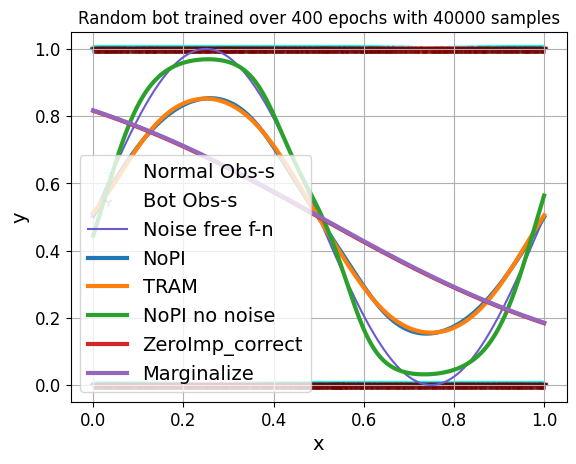

In [21]:
plt.scatter(x[np.where(a==0)], y[np.where(a==0)], c='cyan', label='Normal Obs-s', marker='+', alpha=0.09)
plt.scatter(x[np.where(a==1)], y[np.where(a==1)], c='maroon', label='Bot Obs-s', marker='1', alpha=0.09)
plt.plot(x_pred, (y_true + 1) / 2, c='slateblue', label='Noise free f-n')
for key, y_pred in y_preds.items():
    print(f'{key} loss: {round(mean_squared_error(y_pred, (y_true + 1) / 2), 3)}')
    plt.plot(x_pred, y_pred, label=key, lw=3)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Random bot trained over {num_epochs} epochs with {num_points} samples')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
num_points = 10000
x = np.random.rand(num_points)
a = np.random.binomial(1, 0.3, num_points)
v = np.random.uniform(-1, 1, num_points)
#a = np.zeros(num_points)

y_score = (1-a) * np.sin(2 * np.pi * x) + a * np.random.binomial(1, 0.7, num_points)
#y_score = (1-a) * np.sin(2 * np.pi * x) + a * np.cos(2 * np.pi * x)
y = np.random.binomial(1, (y_score + 1) / 2, num_points)

x_pred = np.linspace(0, 1, num_points)
y_true = np.sin(2 * np.pi * x_pred)

In [23]:
y_preds = {}
x_tensor = torch.tensor(x).float().unsqueeze(1)
a_tensor = torch.tensor(a).float().unsqueeze(1)
y_tensor = torch.tensor(y).float().unsqueeze(1)
num_epochs = 400

for model_class in [NoPI, TRAM]:
    # fit NN
    model = fit_model(x_tensor, a_tensor, y_tensor, model_class, num_epochs=num_epochs)
    
    # fit l2 regression
    with torch.no_grad():
        features = model(torch.from_numpy(x).float().unsqueeze(1), return_representation=True).numpy()
        features_pred = model(torch.from_numpy(x_pred).float().unsqueeze(1), return_representation=True).numpy()
        
    logistic_model = LogisticRegression(penalty='l2', solver='saga', C=1.)
    logistic_model.fit(features, y)
    y_preds[model.__class__.__name__] = logistic_model.predict_proba(features_pred)[:, 1]


# fit NoPI model to uncorrupted data
model = fit_model(x_tensor[a_tensor==0].unsqueeze(1), 
                  a_tensor[a_tensor==0].unsqueeze(1), 
                  y_tensor[a_tensor==0].unsqueeze(1), 
                  NoPI, num_epochs=num_epochs)

# fit l2 regression
with torch.no_grad():
    features = model(torch.from_numpy(x[a==0]).float().unsqueeze(1), return_representation=True).numpy()
    features_pred = model(torch.from_numpy(x_pred).float().unsqueeze(1), return_representation=True).numpy()
    
logistic_model = LogisticRegression(penalty='l2', solver='saga', C=1.)
logistic_model.fit(features, y[a==0])
y_preds[model.__class__.__name__ + ' no noise'] = logistic_model.predict_proba(features_pred)[:, 1]


Epoch [400/400], Loss: 0.1798


/home/danilprov/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch [400/400], Loss: 0.1274


/home/danilprov/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch [400/400], Loss: 0.1274


/home/danilprov/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [24]:
xa = np.column_stack((x, a))
y_given_xa = LogisticRegression(penalty='l2', solver='lbfgs', C=1.)
y_given_xa.fit(xa, y)


xa_pred = np.column_stack((x_pred, np.zeros_like(x_pred)))
y_preds['ZeroImp_correct'] = y_given_xa.predict_proba(xa_pred)[:, 1]

p_z1 = np.mean(a)  # Mean of y when a=0
p_y_given_xz0 = y_given_xa.predict_proba(np.column_stack((x_pred, np.zeros_like(x_pred))))[:, 1]
p_y_given_xz1 = y_given_xa.predict_proba(np.column_stack((x_pred, np.ones_like(x_pred))))[:, 1]
p_y_given_x = (1 - p_z1) * p_y_given_xz0 + p_z1 * p_y_given_xz1

y_preds['Marginalize'] = p_y_given_x

NoPI loss: 0.022
TRAM loss: 0.022
NoPI no noise loss: 0.001
ZeroImp_correct loss: 0.046
Marginalize loss: 0.062


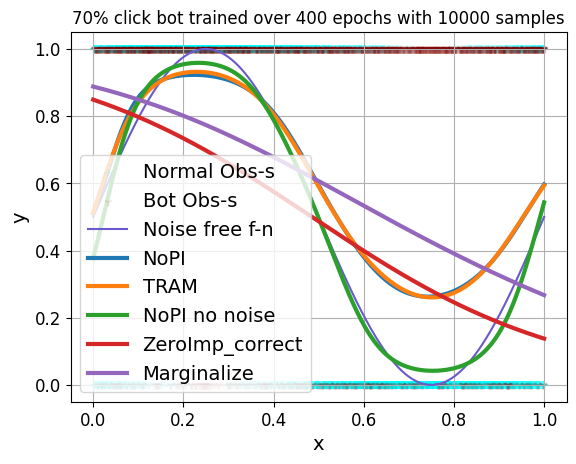

In [25]:
plt.scatter(x[np.where(a==0)], y[np.where(a==0)], c='cyan', label='Normal Obs-s', marker='+', alpha=0.09)
plt.scatter(x[np.where(a==1)], y[np.where(a==1)], c='maroon', label='Bot Obs-s', marker='1', alpha=0.09)
plt.plot(x_pred, (y_true + 1) / 2, c='slateblue', label='Noise free f-n')
for key, y_pred in y_preds.items():
    print(f'{key} loss: {round(mean_squared_error(y_pred, (y_true + 1) / 2), 3)}')
    plt.plot(x_pred, y_pred, label=key, lw=3)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'70% click bot trained over {num_epochs} epochs with {num_points} samples')
plt.legend()
plt.grid(True)
plt.show()

### define 4 data regimes

In [26]:
def generate_click_bot(bot_type, num_points = 2500):
    x = np.random.rand(num_points)
    a = np.random.binomial(1, 0.3, num_points)

    if bot_type == 'deterministic':
        v = 1
    elif bot_type == 'bernoulli':
        v = np.random.binomial(1, 0.7, num_points)
    elif bot_type == 'random':
        v = np.random.uniform(-1, 1, num_points)
    elif bot_type == 'cosin':
        v = np.cos(2 * np.pi * x)

    y_score = (1-a) * np.sin(2 * np.pi * x) + a * v
    y = np.random.binomial(1, (y_score + 1) / 2, num_points)

    x_pred = np.linspace(0, 1, num_points)
    y_true = np.sin(2 * np.pi * x_pred)

    return x, a, y, x_pred, y_true

## Sample efficiency

Epoch [50/50], Loss: 0.1923
Epoch [50/50], Loss: 0.1154
Epoch [50/50], Loss: 0.1880
NoPI loss: 0.063
TRAM loss: 0.037
TRAM zeros loss: 0.036


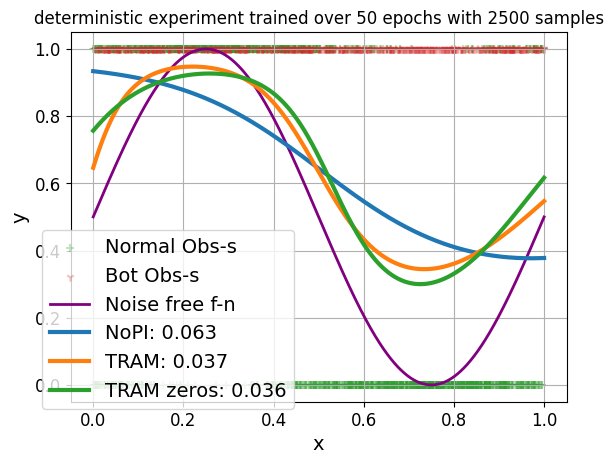

Epoch [50/50], Loss: 0.2048
Epoch [50/50], Loss: 0.1506
Epoch [50/50], Loss: 0.2072
NoPI loss: 0.055
TRAM loss: 0.024
TRAM zeros loss: 0.035


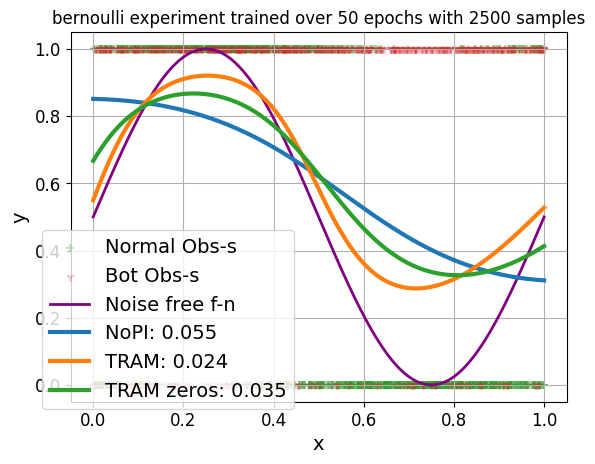

Epoch [50/50], Loss: 0.2094
Epoch [50/50], Loss: 0.1923
Epoch [50/50], Loss: 0.2043
NoPI loss: 0.043
TRAM loss: 0.014
TRAM zeros loss: 0.013


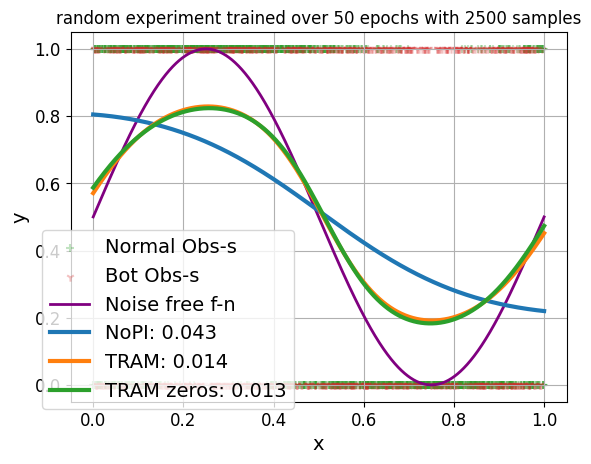

Epoch [50/50], Loss: 0.2073
Epoch [50/50], Loss: 0.1971
Epoch [50/50], Loss: 0.2055
NoPI loss: 0.049
TRAM loss: 0.029
TRAM zeros loss: 0.033


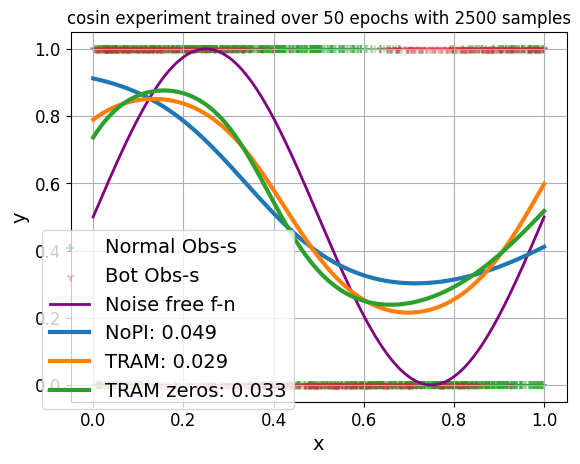

In [27]:
num_epochs = 50
num_points = 2500
for bot_type in ['deterministic', 'bernoulli', 'random', 'cosin']:
    x, a, y, x_pred, y_true = generate_click_bot(bot_type)

    y_preds = {}
    x_tensor = torch.tensor(x).float().unsqueeze(1)
    a_tensor = torch.tensor(a).float().unsqueeze(1)
    y_tensor = torch.tensor(y).float().unsqueeze(1)
    
    for model_class in [NoPI, TRAM]:
        # fit NN
        model = fit_model(x_tensor, a_tensor, y_tensor, model_class, num_epochs=num_epochs)
        
        # fit l2 regression
        with torch.no_grad():
            features = model(torch.from_numpy(x).float().unsqueeze(1), return_representation=True).numpy()
            features_pred = model(torch.from_numpy(x_pred).float().unsqueeze(1), return_representation=True).numpy()
            
        logistic_model = LogisticRegression(penalty='l2', solver='lbfgs', C=1., random_state=42)
        logistic_model.fit(features, y)
        y_preds[model.__class__.__name__] = logistic_model.predict_proba(features_pred)[:, 1]

    # TRAM with zero input
    zero_tensor = torch.zeros_like(a_tensor)
    model = fit_model(x_tensor, zero_tensor, y_tensor, TRAM, num_epochs=num_epochs)
        
    # fit l2 regression
    with torch.no_grad():
        features = model(torch.from_numpy(x).float().unsqueeze(1), return_representation=True).numpy()
        features_pred = model(torch.from_numpy(x_pred).float().unsqueeze(1), return_representation=True).numpy()
        
    logistic_model = LogisticRegression(penalty='l2', solver='lbfgs', C=1., random_state=42)
    logistic_model.fit(features, y)
    y_preds['TRAM zeros'] = logistic_model.predict_proba(features_pred)[:, 1]
    
    plt.scatter(x[np.where(a==0)], y[np.where(a==0)], c='tab:green', label='Normal Obs-s', marker='+', alpha=0.29)
    plt.scatter(x[np.where(a==1)], y[np.where(a==1)], c='tab:red', label='Bot Obs-s', marker='1', alpha=0.29)
    plt.plot(x_pred, (y_true + 1) / 2, c='purple', label='Noise free f-n', lw=2)
    for key, y_pred in y_preds.items():
        loss = round(mean_squared_error(y_pred, (y_true + 1) / 2), 3)
        print(f'{key} loss: {loss}')
        plt.plot(x_pred, y_pred, label=key + ': ' + str(loss), lw=3)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'{bot_type} experiment trained over {num_epochs} epochs with {num_points} samples')
    plt.legend(loc='best', bbox_to_anchor=(0.47, 0.49))
    plt.grid(True)
    plt.savefig(f'pics/{bot_type}_exp_{num_epochs}_{num_points}.pdf', bbox_inches='tight')
    plt.show()

Epoch [200/200], Loss: 0.1659
Epoch [200/200], Loss: 0.0910
Epoch [200/200], Loss: 0.1649
NoPI loss: 0.035
TRAM loss: 0.035
TRAM zeros loss: 0.035


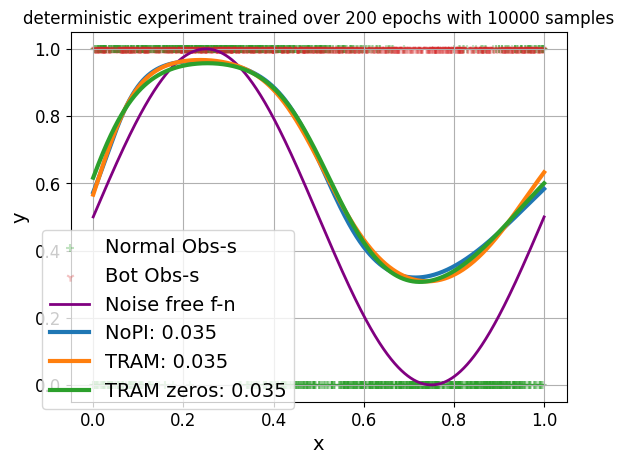

Epoch [200/200], Loss: 0.1904
Epoch [200/200], Loss: 0.1342
Epoch [200/200], Loss: 0.1859
NoPI loss: 0.025
TRAM loss: 0.022
TRAM zeros loss: 0.023


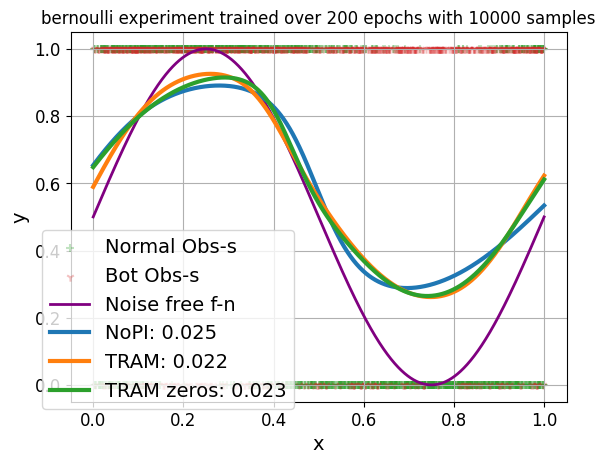

Epoch [200/200], Loss: 0.1968
Epoch [200/200], Loss: 0.1567
Epoch [200/200], Loss: 0.1871
NoPI loss: 0.012
TRAM loss: 0.011
TRAM zeros loss: 0.011


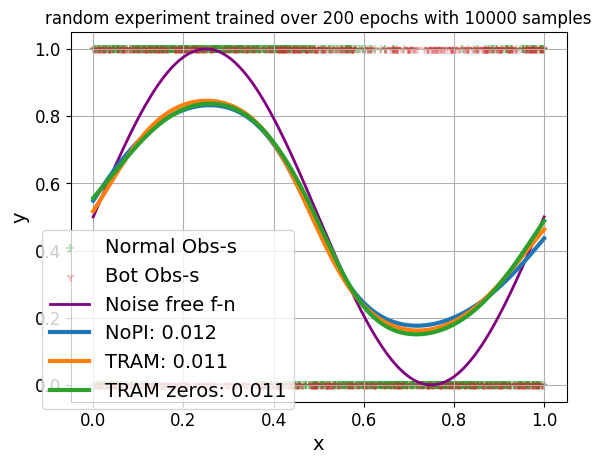

Epoch [200/200], Loss: 0.1747
Epoch [200/200], Loss: 0.1212
Epoch [200/200], Loss: 0.1750
NoPI loss: 0.021
TRAM loss: 0.021
TRAM zeros loss: 0.021


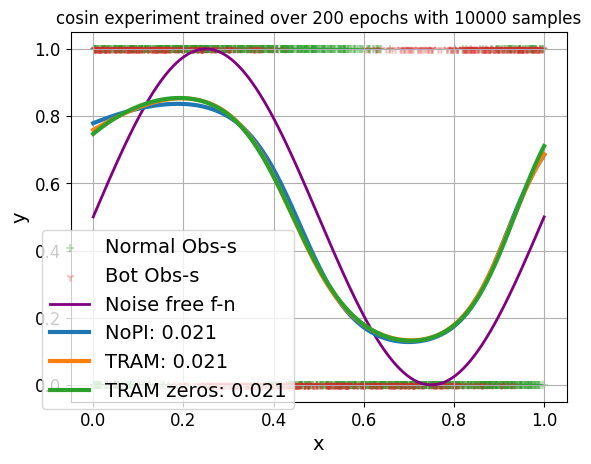

In [28]:
num_epochs = 200
num_points = 10000
for bot_type in ['deterministic', 'bernoulli', 'random', 'cosin']:
    x, a, y, x_pred, y_true = generate_click_bot(bot_type)

    y_preds = {}
    x_tensor = torch.tensor(x).float().unsqueeze(1)
    a_tensor = torch.tensor(a).float().unsqueeze(1)
    y_tensor = torch.tensor(y).float().unsqueeze(1)
    
    for model_class in [NoPI, TRAM]:
        # fit NN
        model = fit_model(x_tensor, a_tensor, y_tensor, model_class, num_epochs=num_epochs)
        
        # fit l2 regression
        with torch.no_grad():
            features = model(torch.from_numpy(x).float().unsqueeze(1), return_representation=True).numpy()
            features_pred = model(torch.from_numpy(x_pred).float().unsqueeze(1), return_representation=True).numpy()
            
        logistic_model = LogisticRegression(penalty='l2', solver='lbfgs', C=1., random_state=42)
        logistic_model.fit(features, y)
        y_preds[model.__class__.__name__] = logistic_model.predict_proba(features_pred)[:, 1]

    # TRAM with zero input
    zero_tensor = torch.zeros_like(a_tensor)
    model = fit_model(x_tensor, zero_tensor, y_tensor, TRAM, num_epochs=num_epochs)
    
    # fit l2 regression
    with torch.no_grad():
        features = model(torch.from_numpy(x).float().unsqueeze(1), return_representation=True).numpy()
        features_pred = model(torch.from_numpy(x_pred).float().unsqueeze(1), return_representation=True).numpy()
        
    logistic_model = LogisticRegression(penalty='l2', solver='lbfgs', C=1., random_state=42)
    logistic_model.fit(features, y)
    y_preds['TRAM zeros'] = logistic_model.predict_proba(features_pred)[:, 1]
    
    plt.scatter(x[np.where(a==0)], y[np.where(a==0)], c='tab:green', label='Normal Obs-s', marker='+', alpha=0.29)
    plt.scatter(x[np.where(a==1)], y[np.where(a==1)], c='tab:red', label='Bot Obs-s', marker='1', alpha=0.29)
    plt.plot(x_pred, (y_true + 1) / 2, c='purple', label='Noise free f-n', lw=2)
    for key, y_pred in y_preds.items():
        loss = round(mean_squared_error(y_pred, (y_true + 1) / 2), 3)
        print(f'{key} loss: {loss}')
        plt.plot(x_pred, y_pred, label=key + ': ' + str(loss), lw=3)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'{bot_type} experiment trained over {num_epochs} epochs with {num_points} samples')
    plt.legend(loc='best', bbox_to_anchor=(0.47, 0.49))
    plt.grid(True)
    plt.savefig(f'pics/{bot_type}_exp_{num_epochs}_{num_points}.pdf', bbox_inches='tight')
    plt.show()

In [29]:
bot_types = ['deterministic', 'bernoulli', 'random', 'cosin']
models = [NoPI, TRAM]
num_epochs = 200
points = [100, 250, 500, 750, 1000, 2500, 5000, 7500, 10000]
num_runs = 10

result_sample_ef = np.zeros((len(bot_types), len(points), len(models), num_runs))

for k in range(num_runs):
    for i, bot_type in enumerate(bot_types):
        for j, num_points in enumerate(points):
            x, a, y, x_pred, y_true = generate_click_bot(bot_type, num_points=num_points)
            for l, model_class in enumerate(models):
                x_tensor = torch.tensor(x).float().unsqueeze(1)
                a_tensor = torch.tensor(a).float().unsqueeze(1)
                y_tensor = torch.tensor(y).float().unsqueeze(1)
    
                # fit NN
                model = fit_model(x_tensor, a_tensor, y_tensor, model_class, num_epochs=num_epochs)
    
                with torch.no_grad():
                    features = model(torch.from_numpy(x).float().unsqueeze(1), return_representation=True).numpy()
                    features_pred = model(torch.from_numpy(x_pred).float().unsqueeze(1), return_representation=True).numpy()
                # fit l2 regression
                logistic_model = LogisticRegression(penalty='l2', solver='lbfgs', C=1.)
                logistic_model.fit(features, y)
                y_pred = logistic_model.predict_proba(features_pred)[:, 1]
                y_loss = mean_squared_error(y_pred, (y_true + 1) / 2)
                result_sample_ef[i, j, l, k] += y_loss

Epoch [200/200], Loss: 0.1771
Epoch [200/200], Loss: 0.0892
Epoch [200/200], Loss: 0.1604
Epoch [200/200], Loss: 0.1000
Epoch [200/200], Loss: 0.1565
Epoch [200/200], Loss: 0.0860
Epoch [200/200], Loss: 0.1590
Epoch [200/200], Loss: 0.0923
Epoch [200/200], Loss: 0.1680
Epoch [200/200], Loss: 0.0905
Epoch [200/200], Loss: 0.1682
Epoch [200/200], Loss: 0.0868
Epoch [200/200], Loss: 0.1669
Epoch [200/200], Loss: 0.0886
Epoch [200/200], Loss: 0.1675
Epoch [200/200], Loss: 0.0862
Epoch [200/200], Loss: 0.1728
Epoch [200/200], Loss: 0.0885
Epoch [200/200], Loss: 0.1775
Epoch [200/200], Loss: 0.1153
Epoch [200/200], Loss: 0.1834
Epoch [200/200], Loss: 0.1471
Epoch [200/200], Loss: 0.1829
Epoch [200/200], Loss: 0.1389
Epoch [200/200], Loss: 0.1872
Epoch [200/200], Loss: 0.1213
Epoch [200/200], Loss: 0.1770
Epoch [200/200], Loss: 0.1320
Epoch [200/200], Loss: 0.1789
Epoch [200/200], Loss: 0.1280
Epoch [200/200], Loss: 0.1749
Epoch [200/200], Loss: 0.1254
Epoch [200/200], Loss: 0.1777
Epoch [200

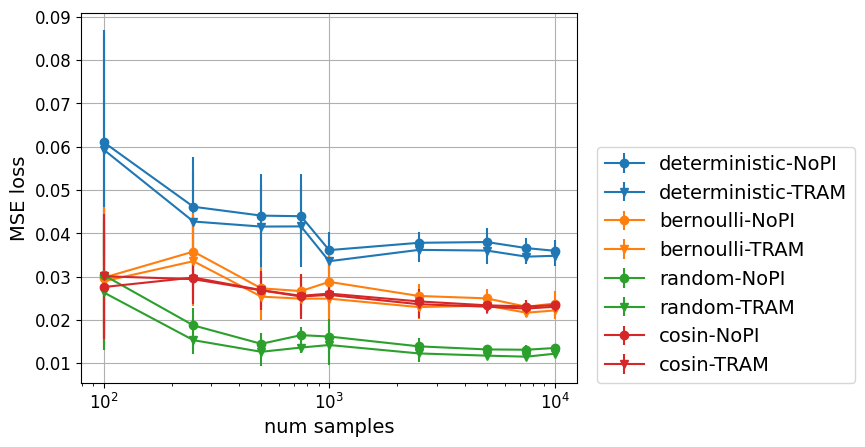

In [30]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
markers = ['o', 'v', 's']
for i, bot_type in enumerate(bot_types):
    for j, model in enumerate(models):
        label = bot_types[i] + '-' + models[j].__name__
        #plt.plot(epochs, result[i, j], color=colors[i], marker=markers[j], label=label, lw=1)
        plt.errorbar(points, 
                     result_sample_ef[i, :, j].mean(axis=-1), 
                     result_sample_ef[i, :, j].std(axis=-1), 
                     marker=markers[j], label=label, color=colors[i])
plt.xlabel('num samples')
plt.ylabel('MSE loss')
#plt.title(f'Tram and NoPI for 3 data regimes. Results averaged over {num_runs} runs.')
plt.legend(loc=(1.04, 0))
plt.xscale('log')
plt.grid(True)
plt.show()

### Convergence rate

In [31]:
bot_types = ['deterministic', 'bernoulli', 'random', 'cosin']
models = [NoPI, TRAM]
epochs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200]
num_runs = 10

result_conv_rate = np.zeros((len(bot_types), len(models), len(epochs), num_runs))

for k in range(num_runs):
    for i, bot_type in enumerate(bot_types):
        x, a, y, x_pred, y_true = generate_click_bot(bot_type)
        for j, model_class in enumerate(models):
            x_tensor = torch.tensor(x).float().unsqueeze(1)
            a_tensor = torch.tensor(a).float().unsqueeze(1)
            y_tensor = torch.tensor(y).float().unsqueeze(1)
    
            for l, num_epochs in enumerate(epochs):
                # fit NN
                model = fit_model(x_tensor, a_tensor, y_tensor, model_class, num_epochs=num_epochs)

                with torch.no_grad():
                    features = model(torch.from_numpy(x).float().unsqueeze(1), return_representation=True).numpy()
                    features_pred = model(torch.from_numpy(x_pred).float().unsqueeze(1), return_representation=True).numpy()
                # fit l2 regression
                logistic_model = LogisticRegression(penalty='l2', solver='lbfgs', C=1.)
                logistic_model.fit(features, y)
                y_pred = logistic_model.predict_proba(features_pred)[:, 1]
                y_loss = mean_squared_error(y_pred, (y_true + 1) / 2)
                result_conv_rate[i, j, l, k] += y_loss

Epoch [10/10], Loss: 0.3652
Epoch [20/20], Loss: 0.1909
Epoch [30/30], Loss: 0.1954
Epoch [40/40], Loss: 0.1915
Epoch [50/50], Loss: 0.1908
Epoch [60/60], Loss: 0.1901
Epoch [70/70], Loss: 0.1901
Epoch [80/80], Loss: 0.1882
Epoch [90/90], Loss: 0.1893
Epoch [100/100], Loss: 0.1798
Epoch [120/120], Loss: 0.1892
Epoch [140/140], Loss: 0.1790
Epoch [160/160], Loss: 0.1702
Epoch [180/180], Loss: 0.1699
Epoch [200/200], Loss: 0.1685
Epoch [10/10], Loss: 0.2565
Epoch [20/20], Loss: 0.1716
Epoch [30/30], Loss: 0.1313
Epoch [40/40], Loss: 0.1117
Epoch [50/50], Loss: 0.1138
Epoch [60/60], Loss: 0.1071
Epoch [70/70], Loss: 0.1015
Epoch [80/80], Loss: 0.1020
Epoch [90/90], Loss: 0.0952
Epoch [100/100], Loss: 0.0979
Epoch [120/120], Loss: 0.0884
Epoch [140/140], Loss: 0.0918
Epoch [160/160], Loss: 0.0959
Epoch [180/180], Loss: 0.0899
Epoch [200/200], Loss: 0.0870
Epoch [10/10], Loss: 0.2115
Epoch [20/20], Loss: 0.2137
Epoch [30/30], Loss: 0.2112
Epoch [40/40], Loss: 0.2079
Epoch [50/50], Loss: 0.2

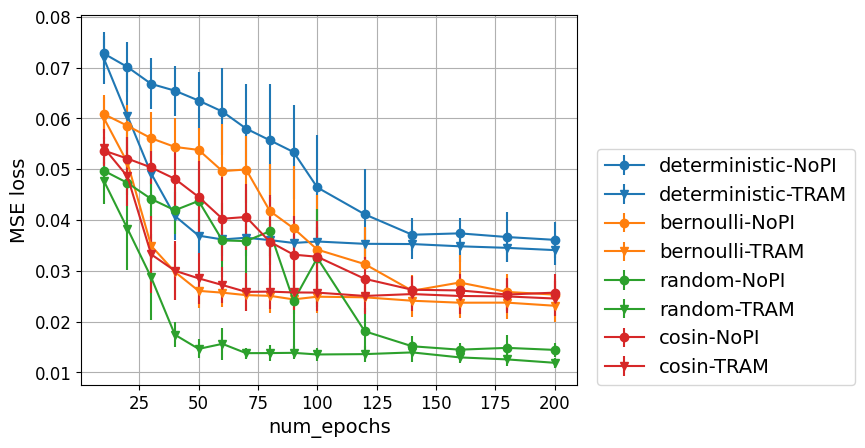

In [32]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
markers = ['o', 'v', 's']
for i, bot_type in enumerate(bot_types):
    for j, model in enumerate(models):
        label = bot_types[i] + '-' + models[j].__name__
        #plt.plot(epochs, result[i, j], color=colors[i], marker=markers[j], label=label, lw=1)
        plt.errorbar(epochs, 
                     result_conv_rate[i, j].mean(axis=-1), 
                     result_conv_rate[i, j].std(axis=-1), 
                     marker=markers[j], label=label, color=colors[i])
plt.xlabel('num_epochs')
plt.ylabel('MSE loss')
#plt.title(f'Tram and NoPI for 3 data regimes. Results averaged over {num_runs} runs.')
plt.legend(loc=(1.04, 0))
plt.grid(True)
plt.show()

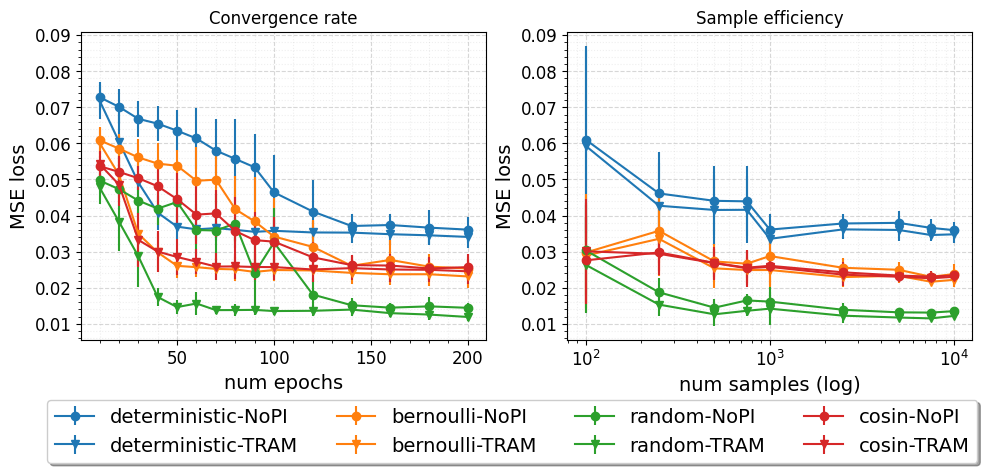

In [33]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(11.5, 4))

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
markers = ['o', 'v', 's']

for i, bot_type in enumerate(bot_types):
    for j, model in enumerate(models):
        label = bot_types[i] + '-' + models[j].__name__
        #plt.plot(epochs, result[i, j], color=colors[i], marker=markers[j], label=label, lw=1)
        ax[0].errorbar(epochs, 
                     result_conv_rate[i, j].mean(axis=-1), 
                     result_conv_rate[i, j].std(axis=-1), 
                     marker=markers[j], label=label, color=colors[i])

for i, bot_type in enumerate(bot_types):
    for j, model in enumerate(models):
        label = bot_types[i] + '-' + models[j].__name__
        #plt.plot(epochs, result[i, j], color=colors[i], marker=markers[j], label=label, lw=1)
        ax[1].errorbar(points, 
                     result_sample_ef[i, :, j].mean(axis=-1), 
                     result_sample_ef[i, :, j].std(axis=-1), 
                     marker=markers[j], color=colors[i])

ax[0].grid(visible=True, which='major', linestyle='--', alpha=0.5)
ax[0].minorticks_on()
ax[0].grid(visible=True, which='minor', linestyle=':', alpha=0.2)
ax[0].set_xlabel('num epochs')
ax[0].set_ylabel('MSE loss')
ax[0].title.set_text('Convergence rate')

ax[1].grid(visible=True, which='major', linestyle='--', alpha=0.5)
ax[1].minorticks_on()
ax[1].grid(visible=True, which='minor', linestyle=':', alpha=0.2)
ax[1].set_xlabel('num samples (log)')
ax[1].set_xscale('log')
ax[1].set_ylabel('MSE loss')
ax[1].title.set_text('Sample efficiency')
ax[1].yaxis.set_tick_params(labelbottom=True)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.015),
          ncol=4, fancybox=True, shadow=True)

plt.savefig('pics/conv_rate_sample_eff.pdf', bbox_inches='tight')